In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import pandas as pd
import math
import sys

from IPython.core.debugger import Tracer

In [2]:
data = pd.read_csv("data.csv", index_col="Ind.", sep=",")

In [3]:
P_A = 1e5 # atmosphere pressure WARNING (can be not 1e5)
R = 8.314
delta = 0.1

def init():
    global P_A
#     sys.stderr.write("P_a = %f" % (P_A))
    
    x = lambda T: T / 1e4
    
    data["sigmaN2"] = (data["sigma"] + data["sigma"]["N2"]) / 2.0
    data["epsilonN2"] = np.sqrt(data["epsilon"] * data["epsilon"]["N2"])
    data["muN2"] =  2 * data["mu"]["N2"] * data["mu"] / (data["mu"]["N2"] + data["mu"])
    
    def generate(subst):
        data.loc[subst, "omega"] = lambda T: 1.074 * np.power(T / data["epsilonN2"][subst], -0.1604)        
        data.loc[subst, "Phi"] = lambda T: \
                      data["f1"][subst] \
                    + data["f2"][subst] * np.log(x(T)) \
                    + data["f3"][subst] * np.power(x(T), -2.0) \
                    + data["f4"][subst] * np.power(x(T), -1.0) \
                    + data["f5"][subst] * x(T) \
                    + data["f6"][subst] * np.power(x(T), 2.0) \
                    + data["f7"][subst] * np.power(x(T), 3.0)
                    
        data.loc[subst, "G"] = lambda T: data["H(298)"][subst] - data["Phi"][subst](T) * T
        
        data.loc[subst, "D"] = lambda T: 2.628e-2 * np.power(T, 3.0 / 2.0) / \
                        (P_A * data["sigmaN2"][subst] * data["omega"][subst](T) * np.sqrt(data["muN2"][subst]))
            
    closure = [generate(subst) for subst in data.index]
    
init()

In [4]:
K = [lambda T: np.exp(-(2 * data["G"]["Al"](T)
                        + 2 * data["G"]["HCl"](T)
                        - 2 * data["G"]["AlCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["Al"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - data["G"]["AlCl2"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T: np.exp(-(2 * data["G"]["Al"](T) 
                        + 6 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["AlCl3"](T) 
                        - 3 * data["G"]["H2"](T)) / (R * T)) * P_A,
     
     lambda T: np.exp(-(2 * data["G"]["Ga"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["GaCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["Ga"](T) 
                        + 2 * data["G"]["HCl"](T) 
                        - data["G"]["GaCl2"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T: np.exp(-(2 * data["G"]["Ga"](T) 
                        + 6 * data["G"]["HCl"](T) 
                        - 2 * data["G"]["GaCl3"](T) 
                        - 3 * data["G"]["H2"](T)) / (R * T)) * P_A,
     
     lambda T: 0,
     
     lambda T: 0,
     
     lambda T: np.exp(-(data["G"]["AlCl3"](T) 
                        + data["G"]["NH3"](T) 
                        - data["G"]["AlN"](T) 
                        - 3 * data["G"]["HCl"](T)) / (R * T)) / P_A,
     
     lambda T: np.exp(-(data["G"]["GaCl"](T)  
                        + data["G"]["NH3"](T) 
                        - data["G"]["GaN"](T) 
                        - data["G"]["HCl"](T) 
                        - data["G"]["H2"](T)) / (R * T)),
     
     lambda T : 0,
     
     lambda T : 0
    ]

In [5]:
def apply_matrix(J, x):
    return np.array([[J[i][j](x) for j in range(J.shape[1])] for i in range(J.shape[0])])

def apply_vector(J, x):
    return np.array([J[i](x) for i in range(J.shape[0])])

def inv(J):
    return np.linalg.inv(J)

def newton_method(J, f, start, max_iter = int(1e3), eps = 1e-5):
    x = start
    for it in range(max_iter):
        J_cur = apply_matrix(J, x)
        f_cur = apply_vector(f, x)
        nx = x - inv(J_cur).dot(f_cur)
        if (np.linalg.norm(nx - x) < eps):
            print("iterations to converge = %d" % (it))
            return x
        x = nx
    assert(False)

In [6]:
def test_newton():
    Tracer()()
    f = \
    [
        lambda x: x[0] + x[1] - 4,
        lambda x: x[0] - x[1]
    ]
    J = \
    [
        [
            lambda x: 1,
            lambda x: 1
        ],
        [
            lambda x: 1,
            lambda x: -1
        ]
    ]

    print(newton_method(np.array(J), np.array(f), np.array([5.3, 1205363])))

In [7]:
# Task1
# 0 -- AlCl
# 1 -- AlCl2
# 2 -- AlCl3
# 3 -- H2
# 4 -- HCl

def solve(T):
    
    subs = ["AlCl", "AlCl2", "AlCl3", "H2", "HCl"]
    
    data.loc["AlCl", "Pg"] = 0
    data.loc["AlCl2", "Pg"] = 0
    data.loc["AlCl3", "Pg"] = 0
    data.loc["H2", "Pg"] = 0
    data.loc["HCl", "Pg"] = 1e4
    
    # Jacobian
    J = \
    [ 
        [ # 0 :::  (PHCl ** 2) - K0 * (PAlCl ** 2) * PH2 = 0
            lambda x: 0 - 2 * K[0](T) * x[0] * x[3], 
            lambda x: 0, 
            lambda x: 0, 
            lambda x: 0 - K[0](T) * x[0] * x[0], 
            lambda x: 2 * x[4]
        ],
    
        [ # 1 ::: (PHCl ** 2) - K1 * PAlCl2 * PH2 = 0
            lambda x: 0, 
            lambda x: 0 - K[1](T) * x[3], 
            lambda x: 0, 
            lambda x: 0 - K[1](T) * x[1], 
            lambda x: 2 * x[4] 
        ],
        
        [ # 2 ::: (PHCl ** 6) - K2 * (PAlCl3 ** 2) * (PH2 ** 3) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0 - 2 * K[2](T) * x[2] * (x[3] ** 3),
            lambda x: 0 - 3 * K[2](T) * (x[2] ** 2) * (x[3] ** 2),
            lambda x: 6 * (x[4] ** 5)
        ],
    
        [ # 3 ::: DHCl(PgHCl - PeHCl) + 2 * DH2 * (PgH2 - PeH2) = 0
            lambda x: 0,
            lambda x: 0,
            lambda x: 0,
            lambda x: -2 * data["D"]["H2"](T),
            lambda x: -1 * data["D"]["HCl"](T),        
        ],
        
        [   # 4 ::: DAlCl(Pg(AlCl) - Pe(AlCl)) 
            #   + 2 * D(AlCl2)(Pg(AlCl2) - Pe(AlCl2)) 
            #   + 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) 
            #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0

            lambda x: -data["D"]["AlCl"](T),
            lambda x: -2 * data["D"]["AlCl2"](T),
            lambda x: -3 * data["D"]["AlCl3"](T),
            lambda x: 0,
            lambda x: -data["D"]["HCl"](T)
        ]
    ]
    
# 0 -- AlCl
# 1 -- AlCl2
# 2 -- AlCl3
# 3 -- H2
# 4 -- HCl

    f = \
    [
    # (PHCl ** 2) - K0 * (PAlCl ** 2) * PH2 = 0
        lambda x: (x[4] ** 2) - K[0](T) * (x[0] ** 2) * x[3]
    ,
    # 1 ::: (PHCl ** 2) - K1 * PAlCl2 * PH2 = 0
        lambda x: (x[4] ** 2) - K[1](T) * x[1] * x[3]
    ,
    # 2 ::: (PHCl ** 6) - K2 * (PAlCl3 ** 2) * (PH2 ** 3) = 0
        lambda x: (x[4] ** 6) - K[2](T) * (x[2] ** 2) * (x[3] ** 3)
    ,
    # 3 ::: D(HCl) * (Pg(HCl) - Pe(HCl)) + 2 * D(H2) * (Pg(H2) - Pe(H2)) = 0
        lambda x: data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4]) \
                    + 2 * data["D"]["H2"](T) * (data["Pg"]["H2"] - x[3])
    ,
    # 4 ::: DAlCl(Pg(AlCl) - Pe(AlCl)) 
      #   + 2 * D(AlCl2)(Pg(AlCl2) - Pe(AlCl2)) 
      #   + 3 * D(AlCl3) * (Pg(AlCl3) - Pe(AlCl3)) 
      #   + D(HCl) * (Pg(HCl) - Pe(HCl)) = 0
        lambda x: data["D"]["AlCl"](T) * (data["Pg"]["AlCl"] - x[0]) \
              + 2 * data["D"]["AlCl2"](T) * (data["Pg"]["AlCl2"] - x[1]) \
              + 3 * data["D"]["AlCl3"](T) * (data["Pg"]["AlCl3"] - x[2]) \
              + data["D"]["HCl"](T) * (data["Pg"]["HCl"] - x[4])
    ]

    
    start = [1,2,3,4,5]
    x = newton_method(np.array(J), np.array(f), start)

# 0 -- AlCl
# 1 -- AlCl2
# 2 -- AlCl3
# 3 -- H2
# 4 -- HCl
    for i in range(len(subs)):
        data.loc[subs[i], "Pe"] = x[i]
    
    for s in subs:
        data.loc[s, "G_flow"] = data.loc[s, "D"](T) * (data.loc[s, "Pg"] - data.loc[s, "Pe"]) / (R * T * delta)

    return [data.loc[s, "G_flow"] for s in subs]

t_cs = np.linspace(350, 650, 20)
y = [list(map(lambda el: np.log(-el), solve(t_c + 273.15))) for t_c in t_cs]
x = [1 / (t_c + 273.15) for t_c in t_cs]

iterations to converge = 56


/usr/lib/python3.5/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in log


iterations to converge = 53
iterations to converge = 51
iterations to converge = 49
iterations to converge = 47
iterations to converge = 44
iterations to converge = 42
iterations to converge = 41
iterations to converge = 39
iterations to converge = 37
iterations to converge = 35
iterations to converge = 34
iterations to converge = 32
iterations to converge = 30
iterations to converge = 29
iterations to converge = 28
iterations to converge = 28
iterations to converge = 28
iterations to converge = 27
iterations to converge = 27


In [8]:
list(map(lambda ys: ys[2], y))

[-6.3421147238157323,
 -6.3255905326237825,
 -6.3094702840584,
 -6.2937351169775066,
 -6.2783677252283328,
 -6.2633523410484706,
 -6.248674764259766,
 -6.2343224573033575,
 -6.220284705873798,
 -6.2065528585473819,
 -6.1931206632993012,
 -6.179984706805441,
 -6.1671449735644446,
 -6.1546055366643841,
 -6.1423753920090682,
 -6.1304694547795293,
 -6.1189097173979583,
 -6.107726591411339,
 -6.0969604350172624,
 -6.0866632762589514]

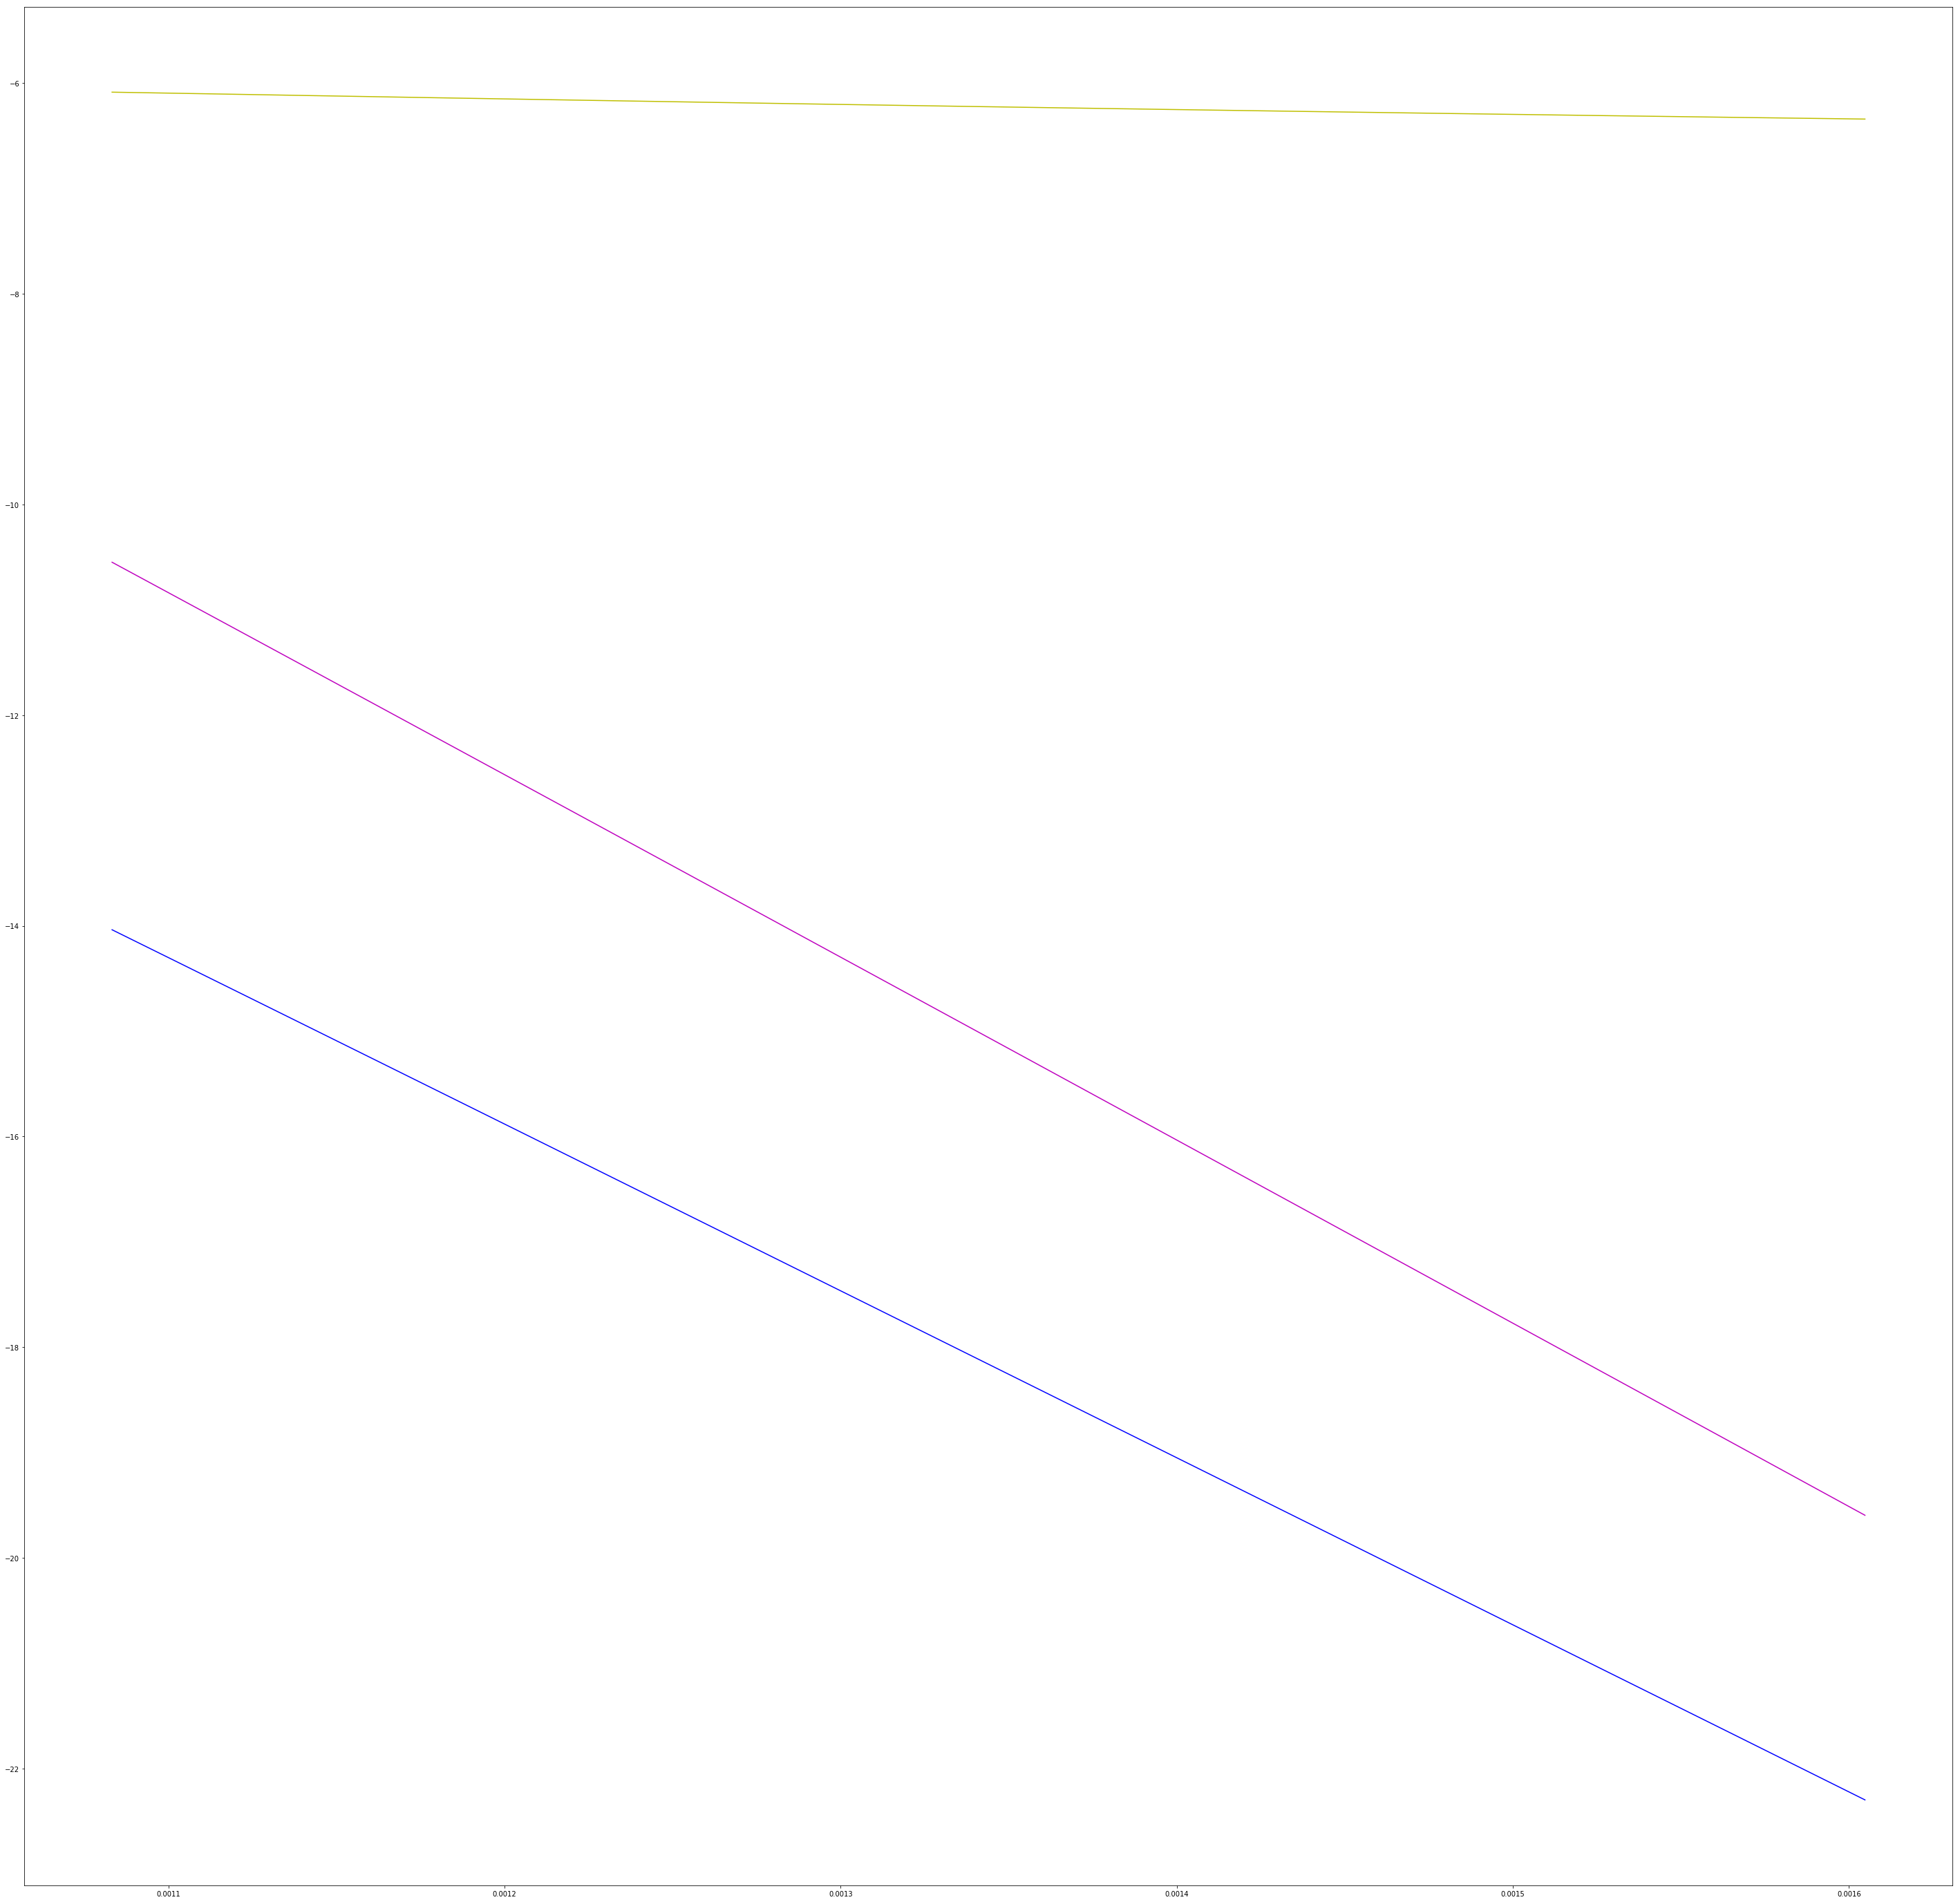

In [9]:
fig, ax = plt.subplots(figsize = (50, 50))
ax.plot(x, list(map(lambda ys: ys[0], y)), color='m')
ax.plot(x, list(map(lambda ys: ys[1], y)), color='b')
ax.plot(x, list(map(lambda ys: ys[2], y)), color='y')
